# Segmentación de conductores para aseguradora

Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sns.set(style="whitegrid")

Cargar el dataset

In [2]:
# Cargar dataset
df = pd.read_csv('conductores_kmeans.csv')
df.head()

,edad,años_experiencia,multas,km_anuales,siniestros
0,56,4,0,17843.604595,0
1,69,36,0,10676.243654,0
2,46,37,1,24112.310116,0
3,32,29,1,18950.355072,0
4,60,8,1,3837.312000,0


EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   edad              1600 non-null   int64  
 1   años_experiencia  1600 non-null   int64  
 2   multas            1600 non-null   int64  
 3   km_anuales        1600 non-null   float64
 4   siniestros        1600 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 62.6 KB
Valores nulos:
 edad                0
años_experiencia    0
multas              0
km_anuales          0
siniestros          0
dtype: int64


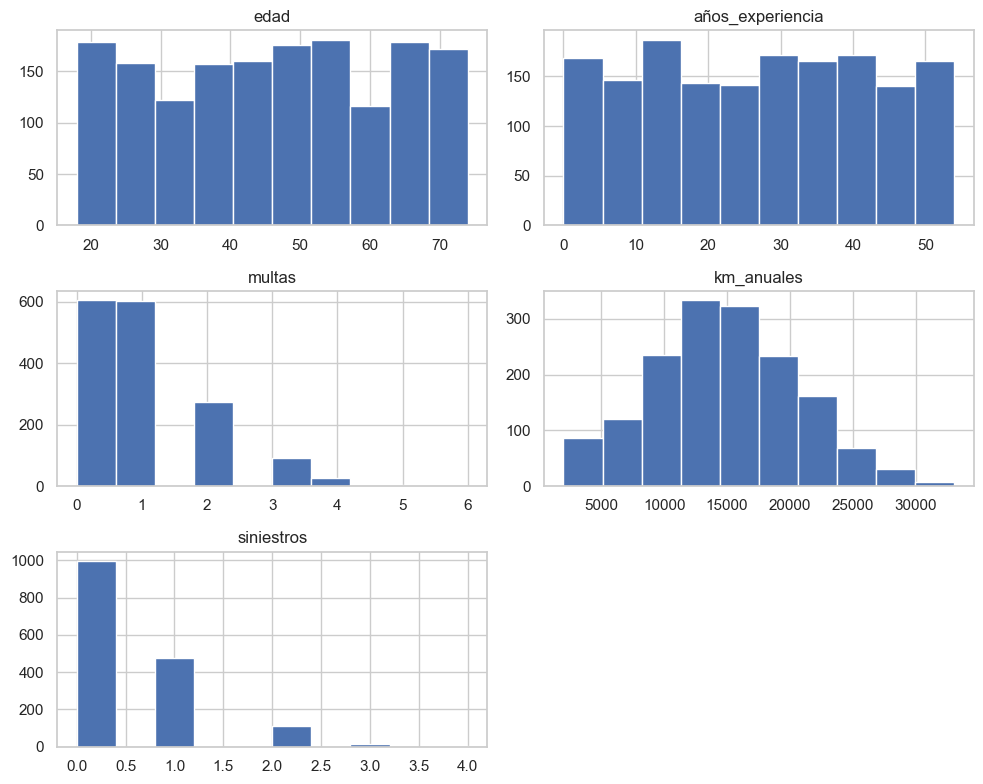

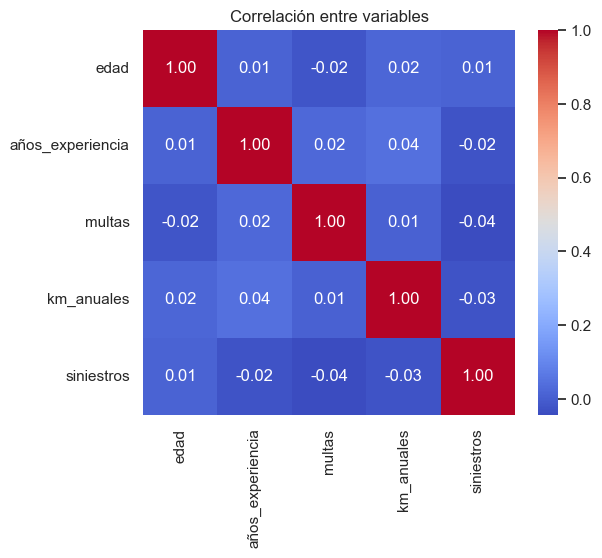

In [3]:
# EDA
df.info()
df.describe().T
print('Valores nulos:\n', df.isnull().sum())

# Distribuciones
df.hist(figsize=(10,8));
plt.tight_layout()

# Correlación
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlación entre variables')
plt.show()

Escalado

In [4]:
# Escalado de variables
X = df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,edad,años_experiencia,multas,km_anuales,siniestros
0,0.592812,-1.455271,-0.980655,0.516976,-0.692866
1,1.380955,0.584922,-0.980655,-0.714515,-0.692866
2,-0.013451,0.648678,0.032288,1.594061,-0.692866
3,-0.862221,0.138630,0.032288,0.707137,-0.692866
4,0.835318,-1.200247,0.032288,-1.889576,-0.692866


Método del codo

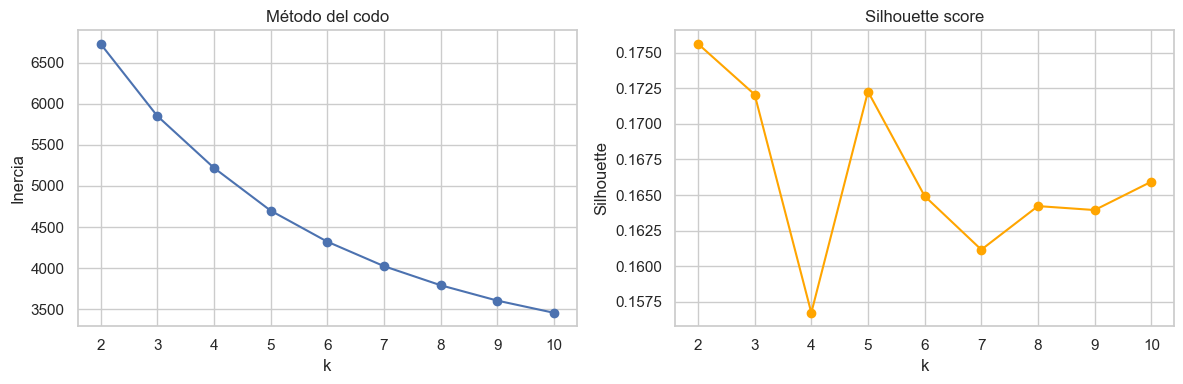

k óptimo por silhouette: 2


In [5]:
# Método del codo (inercia) y silhouette para elegir k
inertias = []
silhouettes = []
K = range(2,11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inercia')
plt.title('Método del codo')

plt.subplot(1,2,2)
plt.plot(K, silhouettes, marker='o', color='orange')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Silhouette score')
plt.tight_layout()
plt.show()

best_k = K[int(np.argmax(silhouettes))]
print('k óptimo por silhouette:', best_k)

Entrenamiento final

In [6]:
# Entrenamiento final con k elegido
k_final = int(best_k) if 'best_k' in globals() else 3
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)
labels = kmeans_final.labels_
df['cluster'] = labels
print(df['cluster'].value_counts())

cluster
1    996
0    604
Name: count, dtype: int64


Interpretación

In [7]:
# Interpretación: centros de cluster (en escala original) y estadísticas por cluster
centers_scaled = kmeans_final.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers, columns=X.columns)
print('Centros de los clusters (en escala original):')
display(centers_df)

# Estadísticas por cluster
for c in sorted(df['cluster'].unique()):
    print(f'--- Cluster {c} ---')
    display(df[df['cluster']==c].describe().T)

Centros de los clusters (en escala original):


,edad,años_experiencia,multas,km_anuales,siniestros
0,46.438742,26.524834,0.905629,14775.662971,1.240066e+00
1,46.090361,27.008032,1.006024,14870.615072,1.776357e-15


--- Cluster 0 ---


,count,mean,std,min,25%,50%,75%,max
edad,604.0,46.438742,16.383097,18.0,33.000000,46.000000,61.000000,74.000000
años_experiencia,604.0,26.524834,15.651926,0.0,13.000000,27.000000,40.000000,54.000000
multas,604.0,0.905629,0.971928,0.0,0.000000,1.000000,1.000000,6.000000
km_anuales,604.0,14775.662971,5930.093322,2000.0,10687.250295,14714.374104,18723.588228,33088.270256
siniestros,604.0,1.240066,0.502383,1.0,1.000000,1.000000,1.000000,4.000000
cluster,604.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


--- Cluster 1 ---


,count,mean,std,min,25%,50%,75%,max
edad,996.0,46.090361,16.576725,18.0,31.750000,46.000000,61.000000,74.000000
años_experiencia,996.0,27.008032,15.717606,0.0,13.750000,27.000000,40.000000,54.000000
multas,996.0,1.006024,0.995449,0.0,0.000000,1.000000,2.000000,5.000000
km_anuales,996.0,14870.615072,5757.983483,2000.0,10947.099469,14640.400122,18730.792115,31613.353858
siniestros,996.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
cluster,996.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000


Visualización

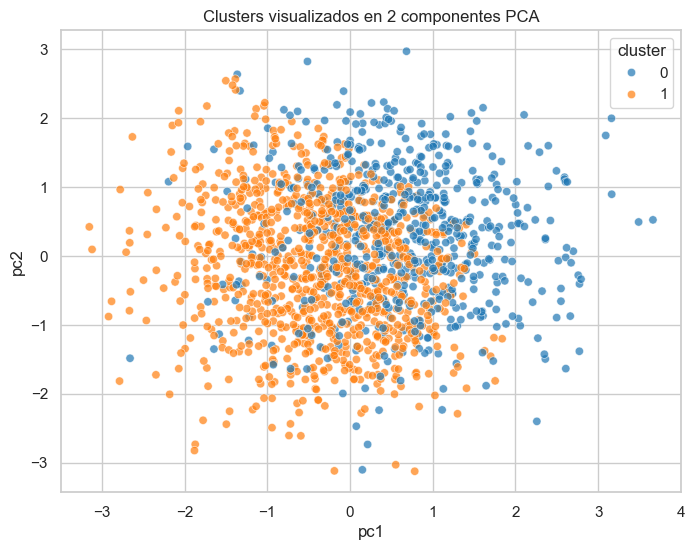

In [8]:
# Visualización con PCA (2 componentes)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['pc1'] = X_pca[:,0]
df['pc2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='pc1', y='pc2', hue='cluster', palette='tab10', alpha=0.7)
plt.title('Clusters visualizados en 2 componentes PCA')
plt.legend(title='cluster')
plt.show()